In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df0 = pd.read_csv('/content/sample12.csv', index_col=0, parse_dates=True)
df0

,temp,year,month,day,hour,person,accum
date,,,,,,,
2021-01-01 00:00:00,-0.8,2021,1,1,0,0,0
2021-01-01 01:00:00,-1.8,2021,1,1,1,0,0
2021-01-01 02:00:00,-2.4,2021,1,1,2,1,1
2021-01-01 03:00:00,-2.9,2021,1,1,3,0,1
2021-01-01 04:00:00,-3.7,2021,1,1,4,0,1
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,3.9,2022,12,31,19,0,7
2022-12-31 20:00:00,3.1,2022,12,31,20,0,7
2022-12-31 21:00:00,2.4,2022,12,31,21,0,7


In [ ]:
df0 = df0.drop(['year','day','hour','month','temp','person'], axis=1)

In [ ]:
df0

,accum
date,
2021-01-01 00:00:00,0
2021-01-01 01:00:00,0
2021-01-01 02:00:00,1
2021-01-01 03:00:00,1
2021-01-01 04:00:00,1
...,...
2022-12-31 19:00:00,7
2022-12-31 20:00:00,7
2022-12-31 21:00:00,7


In [ ]:
df0.reset_index(drop=False,inplace=True)
df0

,date,accum
0,2021-01-01 00:00:00,0
1,2021-01-01 01:00:00,0
2,2021-01-01 02:00:00,1
3,2021-01-01 03:00:00,1
4,2021-01-01 04:00:00,1
...,...,...
17515,2022-12-31 19:00:00,7
17516,2022-12-31 20:00:00,7
17517,2022-12-31 21:00:00,7
17518,2022-12-31 22:00:00,7


In [ ]:
stock_data = df0.groupby([pd.Grouper(key='date',freq='2h')]).max()

In [ ]:
stock_data

,accum
date,
2021-01-01 00:00:00,0
2021-01-01 02:00:00,1
2021-01-01 04:00:00,2
2021-01-01 06:00:00,3
2021-01-01 08:00:00,3
...,...
2022-12-31 14:00:00,5
2022-12-31 16:00:00,6
2022-12-31 18:00:00,7


In [ ]:
len(stock_data['accum'])

8760

In [ ]:
testdata2 = df0.groupby([pd.Grouper(key='date',freq='2h')]).max()

In [ ]:
testdata2.reset_index(drop=False,inplace=True)
testdata2

,date,accum
0,2021-01-01 00:00:00,0
1,2021-01-01 02:00:00,1
2,2021-01-01 04:00:00,2
3,2021-01-01 06:00:00,3
4,2021-01-01 08:00:00,3
...,...,...
8755,2022-12-31 14:00:00,5
8756,2022-12-31 16:00:00,6
8757,2022-12-31 18:00:00,7
8758,2022-12-31 20:00:00,7


In [ ]:
original_open = stock_data['accum'].values
dates = pd.to_datetime(testdata2['date'])

In [ ]:
cols = list(testdata2)[1:2]

stock_data = stock_data[cols].astype(float)

In [ ]:
cols

['accum']

In [ ]:
from sklearn.preprocessing import StandardScaler

# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

In [ ]:
n_train = int(0.9*stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

In [ ]:
import numpy as np
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 14   # sequence length = past days for future prediction.
input_dim = 1  # input_dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/50
222/222 [==============================] - 10s 26ms/step - loss: 0.2772 - val_loss: 0.1144
Epoch 2/50
222/222 [==============================] - 4s 18ms/step - loss: 0.1178 - val_loss: 0.0982
Epoch 3/50
222/222 [==============================] - 4s 18ms/step - loss: 0.0786 - val_loss: 0.0844
Epoch 4/50
222/222 [==============================] - 5s 23ms/step - loss: 0.0718 - val_loss: 0.0899
Epoch 5/50
222/222 [==============================] - 4s 18ms/step - loss: 0.0733 - val_loss: 0.0917
Epoch 6/50
222/222 [==============================] - 4s 18ms/step - loss: 0.0921 - val_loss: 0.1810
Epoch 7/50
222/222 [==============================] - 5s 24ms/step - loss: 0.0711 - val_loss: 0.0798
Epoch 8/50
222/222 [==============================] - 4s 18ms/step - loss: 0.0686 - val_loss: 0.0910
Epoch 9/50
222/222 [==============================] - 4s 18ms/step - loss: 0.0871 - val_loss: 0.1182
Epoch 10/50
222/222 [=======================

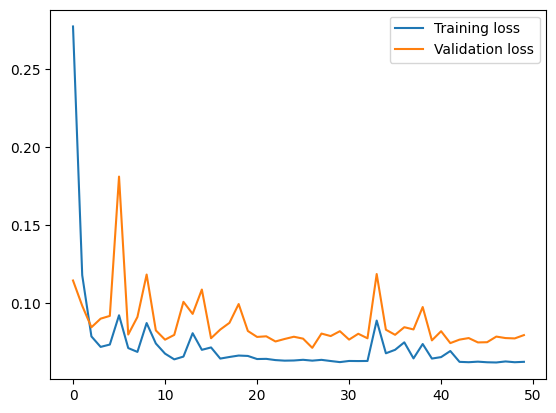

In [ ]:
# Try to load weights
try:
    model.load_weights('./save_weights/lstm_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('/content/lstm_weights.h5')
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [ ]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

27/27 [==============================] - 1s 9ms/step
(862, 1) (862, 1)


In [ ]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

27/27 [==============================] - 0s 7ms/step
(862, 1) (862, 1)
(862,)


In [ ]:
# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

(862,)


In [ ]:
# plotting
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

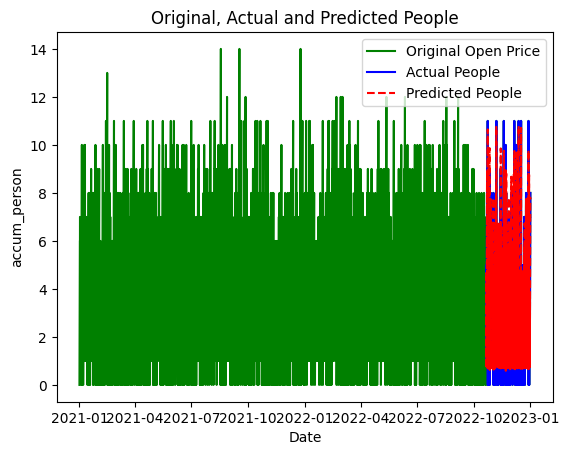

In [ ]:
# plot original 'Open' prices
plt.plot(dates, original_open, color='green', label='Original Open Price')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual People')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted People')
plt.xlabel('Date')
plt.ylabel('accum_person')
plt.title('Original, Actual and Predicted People')
plt.legend()
plt.show()

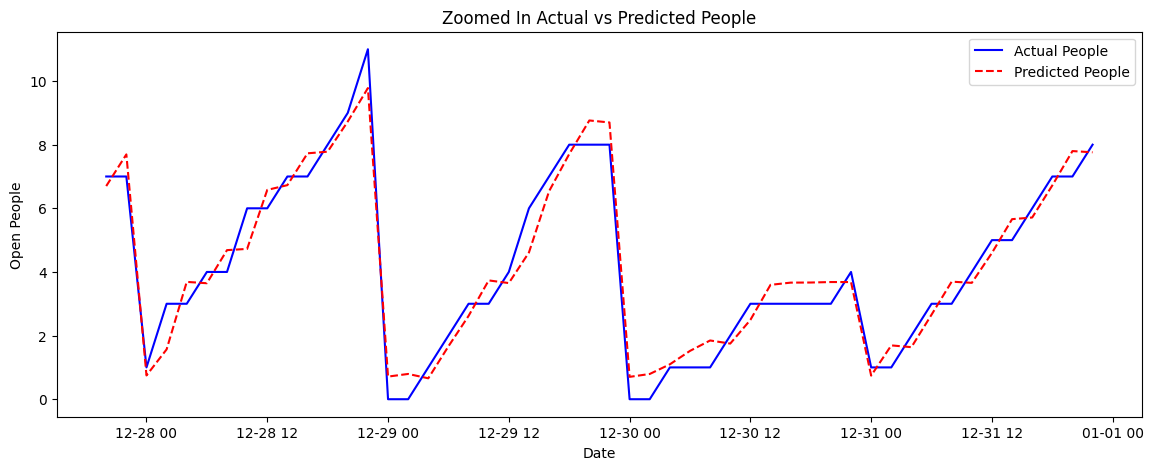

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual People')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted People')

plt.xlabel('Date')
plt.ylabel('Open People')
plt.title('Zoomed In Actual vs Predicted People')
plt.legend()
plt.show()

In [ ]:
y_test = testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start]

In [ ]:
predpred = y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ]

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predpred)
print(f"평균 제곱 오차 (MSE): {mse}")

평균 제곱 오차 (MSE): 0.41007955926018463


In [ ]:
# RMSE 계산
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.6403745460745489
